### CTRP scatterplots

In [142]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from __future__ import division
import operator
import warnings
import os

pd.set_option('display.width',500)
warnings.filterwarnings('ignore')
% matplotlib inline

In [98]:
print os.getcwd()
! ls *.csv

/Users/KAschbacher/Desktop/publications
CTRP_2018-02-24_mini.csv


In [186]:
def winsorize(df, var_name, win_std, high_low):
    """win_std = Number of standard deviations below/above mean that determine the winsorized value."""
    # Settings
    W_var_name = var_name + '_W'# varname for new winsorized variable
    df[W_var_name] = df[var_name]
    
    if high_low=='high':
        win_value = operator.add(df[var_name].mean(), (win_std * df[var_name].std()))# new winsorized value
        n_win = operator.gt(df[var_name], win_value).sum()# number of points to winsorize
        df[W_var_name].loc[operator.gt(df[W_var_name],win_value)] = win_value
    else:
        win_value = operator.sub(df[var_name].mean(), (win_std * df[var_name].std()))# new winsorized value
        n_win = operator.lt(df[var_name], win_value).sum()# number of points to winsorize
        df[W_var_name].loc[operator.lt(df[W_var_name],win_value)] = win_value
    
    print '\nHandling {} outliers for {}...'.format(n_win, var_name)
    print 'Pre-winsorizing min: {}, max: {}, winsorized value: {}\n'.format(df[var_name].min(), df[var_name].max(), win_value)

In [187]:
def run_regression(x, y):
    reg = sm.OLS(y, sm.add_constant(x, prepend=True), missing='drop').fit()
    standB = standardize_betas(x,y,reg) 
    line_values = make_line(x, reg)
    return standB, reg.pvalues[1], line_values

In [188]:
def standardize_betas(x,y,reg):
    """ Calculate the Standardized Coefficient = standB
    B * (Sx/Sy), where Sx = standard dev of x and Sy same w/ y
    http://www.albany.edu/faculty/kretheme/PAD705/SupportMat/StandardizedCeof.pdf
    x and y are series objects, reg is generated from sm.OLS(**kwargs).fit()"""
    B = reg.params[1]
    sx = np.std(x)#ignore intercept
    sy = np.std(y)
    standB = B*(sx/sy)#This matches SPSS perfectly
    return standB

In [189]:
def format_pvalue(p):
    # Round the p-value and add '*'
    pval = '{:.3f}'.format(p)[1:]# remove leading 0
    if p<=.001: 
        pval = u'p≤.001**'
    else: 
        pval = u'p='+pval
        # Add significance mark
        if p<=.01: pval += u'**'
        elif p<=.05: pval += u'*'
        elif p<=.10: pval += u'†'
    return pval

In [190]:
def divide_10(num, counter):
    """Recursive function determines the order of a number.  E.g., 10^2 or 10^3...
    Determines what scale/order the x-axis is on, to get right anchor points for line in the scatterplot."""
    if num>10: 
        counter += 1
        #print 'counter:%d, starting number: %d'%(counter, num)
        divide_10(num/10, counter)
    return counter

In [224]:
def make_line(x, reg):
    """Compute points to draw a fit line for the regression on top of the scatterplot. x is a series"""
    
    # Get min and max X values to make regression line anchors for scatterplot
    x_scale = x.max() - x.min()
    exponent = divide_10(x_scale, 0)# Always start call with 2nd argument=0
    order = np.power(10, exponent)
    
    # DEBUGGING statements
    #print 'Order: %d'%order
    #print 'min x: %d, max x: %d'%(df[x].min(), df[x].max())
    #print 'floor: %d, ceil: %d'%(np.floor((df[x].min()/order)), np.ceil((df[x].max()/order)))
    
    #A Trick which rounds up or down based on desired Order - to closest 10 or 100
    minx = order * np.floor(x.min()/order)
    maxx = order * np.ceil(x.max()/order)
    # Override line coordinates, so both groups are the same
    #minx = -10; maxx = 20;
    
    predy = reg.predict( np.asarray([[1, minx], [1, maxx]]))#Adds intercept back
    predy = np.round(predy,decimals=3)
    #print 'min %d y %03f, and max %d y %03f \n' % (minx, predy[0], maxx, predy[1])
    
    line = np.asarray([[minx, maxx], [predy[0], predy[1]]])
    return line

In [245]:
class Analysis():
    def __init__(self, df, xy_vars, xy_labels, text_position):
        """xy_vars = list [x, y] as string names of columns in df; xy_labels as strings for printing on plot axes"""
        self.x = df[xy_vars[0]]
        self.y = df[xy_vars[1]]
        self.xy_labels = xy_labels
        #self.plot_title = 'Figure 1'

        self.standB, self.p, self.line = run_regression(self.x, self.y)
        self.p = format_pvalue(self.p)
        self.text = u'ß='+'{:.3f}'.format(self.standB)[1:]+', '+self.p# remove leading 0
        
        #Determines proportion of distance along the xaxis that text appears. Whereas line spans xaxis, it does not necessarily capture ymin and ymax
        if text_position=='top_left':
            xprop = .05; yprop=.88
        else:
            xprop = .40; yprop=.01
        xloc = self.line[0][0] + (xprop * (self.line[0][1] - self.line[0][0]))
        yloc = min(self.y) + (yprop * (max(self.y) - min(self.y)))#yloc = yprop*max(self.y)
        self.text_loc = [xloc, yloc]

In [257]:
def scatterplot(g, c):
    """Plot a scatterplot 
    **kwargs:  Analysis class object (stats & labels).  Color class object (formatting)."""

    # Plot
    plt.rcParams.update(c.params)
    fig, ax = plt.subplots()
    plt.scatter(g.x, g.y, s=6, facecolors=c.dots, lw=.5)
    plt.plot(g.line[0], g.line[1], color=c.line, lw=1)
    
    # Settings
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], visible=False)
    plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], fontsize=6.5, color=c.ytl)
    plt.setp([ax.set_xlabel(g.xy_labels[0]), ax.set_ylabel(g.xy_labels[1])], fontsize=9.5, color=c.xlb)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    #plt.title(g.plot_title, fontsize=14)
    
    # Force boundaries of xlim to match line
    plt.xlim(g.line[0][0], g.line[0][1])
    
    # Add p-values as a text annotation
    ax.text(g.text_loc[0], g.text_loc[1], g.text, fontsize=7.5, color=c.text, style='italic')
    
    return fig

In [264]:
class Formater:
    def __init__(self):
        
        # Color scheme
        dark_grey='#282828'; med4_grey='#404040'; med3_grey='#686868'; med2_grey='#808080';
        
        # Assign color to each graph component
        self.dots = dark_grey
        self.line = med3_grey
        self.err = med2_grey
        self.edge = med2_grey
        self.xlb = dark_grey
        self.ylb = dark_grey
        self.xtk = med3_grey
        self.ytk = med3_grey
        self.ytl = med3_grey
        self.leg = med3_grey
        self.box = med4_grey
        self.text = med4_grey#p-value annotated on top of graph
        
        # Set RC-params - changes global settings
        self.params = {
            'figure.figsize':(2.25, 2.25),
            'axes.facecolor':'white',
            'axes.grid':False}
#             'axes.edgecolor': med3_grey,
#             'axes.labelcolor': med3_grey}

['uniqueid', 'FILTER_IL1b_PSSIsev_TSCpst', 'bl_IL1B_T0', 'StdRes_bl_IL1b', 'bl_IL6_T0', 'StdRes_bl_IL6', 'bl_IL10_T0', 'StdRes_bl_IL10', 'bl_CRP_T0', 'StdRes_bl_CRP', 'StdRes_pssi_sev', 'StdRes_pssi_ar', 'StdRes_pssi_av', 'StdRes_pssi_reex', 'StdRes_cesd_tot', 'StdRes_tsc_pst', 'StdRes_tsc_int', 'StdRes_tsc_avd', 'StdRes_tsc_ars', 'StdRes_tsc_dis', 'StdRes_tsc_dep', 'StdRes_tsc_anx', 'StdRes_tsc_ang']

N rows and columns: (43, 23)

Handling 1 outliers for StdRes_tsc_pst...
Pre-winsorizing min: -1.59831525899, max: 3.51862218467, winsorized value: 1.92431550951

Saved ./figures/CTRP_StdRes_pssi_sev_2018-02-26.pdf
Saved ./figures/CTRP_StdRes_tsc_pst_W_2018-02-26.pdf


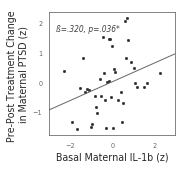

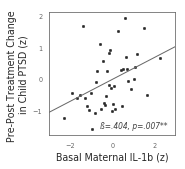

In [265]:
def main():
    
    # Load and filter data
    df = pd.read_csv('CTRP_2018-02-24_mini.csv')
    print df.columns.tolist()
    df = df.loc[df['FILTER_IL1b_PSSIsev_TSCpst']==1]
    print '\nN rows and columns: {}'.format(df.shape)
    
    # Convert Types, Manage outliers
    cols = [col for col in df.columns if col not in ['uniqueid']]
    df[cols] = df[cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    winsorize(df, 'StdRes_tsc_pst', 2, 'high')
    
    # Specify graph parameters
    graph_specs = {'IL1b_PSSIsev':
                      {'x':'bl_IL1B_T0',
                       'y':'StdRes_pssi_sev',
                       'xlabel':'Basal Maternal IL-1b (z)', 
                       'ylabel':'Pre-Post Treatment Change \nin Maternal PTSD (z)',
                       'text_loc':'top_left'},
                  'IL1b_TSC':
                      {'x':'bl_IL1B_T0',
                       'y':'StdRes_tsc_pst_W',
                       'xlabel':'Basal Maternal IL-1b (z)', 
                       'ylabel':'Pre-Post Treatment Change \nin Child PTSD (z)',
                       'text_loc':'lower_right'}
                  }
    
    # Loop through, plot & save scatterplot graphs  
    formater = Formater()
    for spec in graph_specs.itervalues():
        analysis = Analysis(df, [spec['x'], spec['y']], [spec['xlabel'], spec['ylabel']], spec['text_loc'])
        fig = scatterplot(analysis, formater)
        fig_filename = './figures/CTRP_{}_{}.pdf'.format(spec['y'], str(dt.date.today()))
        fig.savefig(fig_filename, bbox_inches='tight', dpi=600)
        print 'Saved {}'.format(fig_filename)
    

if __name__=="__main__":
    main()

In [262]:
import pprint as pp
pp.pprint (plt.rcParams.keys())

[u'_internal.classic_mode',
 u'agg.path.chunksize',
 u'animation.avconv_args',
 u'animation.avconv_path',
 u'animation.bitrate',
 u'animation.codec',
 u'animation.convert_args',
 u'animation.convert_path',
 u'animation.ffmpeg_args',
 u'animation.ffmpeg_path',
 u'animation.frame_format',
 u'animation.html',
 u'animation.mencoder_args',
 u'animation.mencoder_path',
 u'animation.writer',
 u'axes.autolimit_mode',
 u'axes.axisbelow',
 u'axes.edgecolor',
 u'axes.facecolor',
 u'axes.formatter.limits',
 u'axes.formatter.offset_threshold',
 u'axes.formatter.use_locale',
 u'axes.formatter.use_mathtext',
 u'axes.formatter.useoffset',
 u'axes.grid',
 u'axes.grid.axis',
 u'axes.grid.which',
 u'axes.hold',
 u'axes.labelcolor',
 u'axes.labelpad',
 u'axes.labelsize',
 u'axes.labelweight',
 u'axes.linewidth',
 u'axes.prop_cycle',
 u'axes.spines.bottom',
 u'axes.spines.left',
 u'axes.spines.right',
 u'axes.spines.top',
 u'axes.titlepad',
 u'axes.titlesize',
 u'axes.titleweight',
 u'axes.unicode_minus',
